In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [2]:
train = pd.read_csv('c:/data/titanic/train.csv')
test = pd.read_csv('c:/data/titanic/test.csv')
IDtest = test['PassengerId']

In [4]:
# 데이터프레임, 살펴볼 피쳐, 개수를 입력하면 이상치의 인덱스를 리턴하는 함수를 만든다.
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5*IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # outlier_list_col 은 조건에 맞는 인덱스 번호 리턴
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)
    # 탐지된 이상치가 n개 이상인 샘플에 대한 인덱스 리스트를 만든다.
    return multiple_outliers

In [5]:
Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

In [6]:
# 탐지한 이상값을 drop한다.
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [7]:
# 범주형 변수 변환시 같은 수치를 얻기 위해서 트레이닝/테스트 데이터를 합쳐준다.
# 합친 데이터를 분리할 때, 미리 설정해놓은 훈련데이터의 수만큼 분할할 수 있도록 훈련데이터의 개수를 저장해놓는다.
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [8]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

# testset의 Survived 열은 없었기 때문에 testset에 결측치는 무시한다.

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


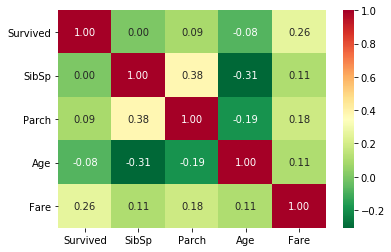

In [22]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt= '.2f', cmap='RdYlGn_r')

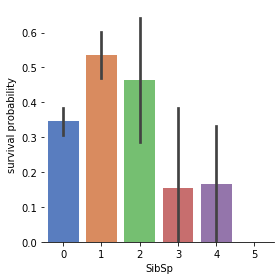

In [31]:
g = sns.catplot(x = 'SibSp', y = 'Survived', data=train, kind= 'bar', height = 4, palette = 'muted')

g.despine(left = True)
g = g.set_ylabels('survival probability')

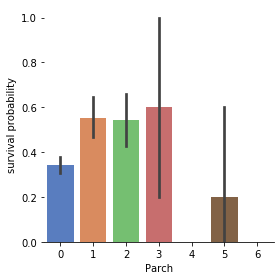

In [32]:
g = sns.catplot(x='Parch',y='Survived',data = train,kind='bar',height=4, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

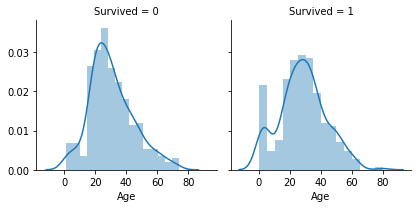

In [93]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

# f, ax = plt.subplots(1,2,figsize=(8,3), sharey='all')
# sns.distplot(train[train['Survived']==0].Age, ax=ax[0])
# sns.distplot(train[train['Survived']==1].Age, ax=ax[1])

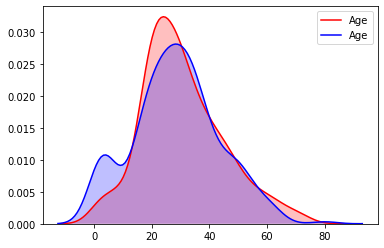

In [95]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color = 'Blue', shade=True)

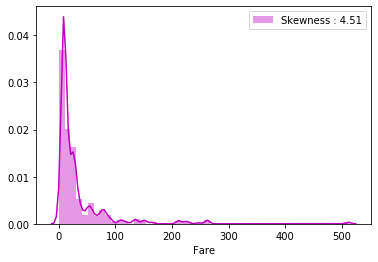

In [98]:
dataset['Fare'].isnull().sum()

dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

In [99]:
dataset['Fare'] = dataset['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

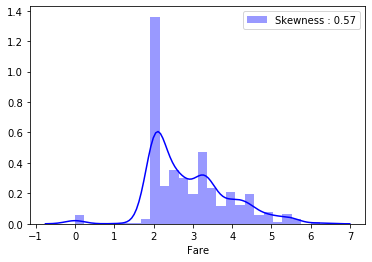

In [101]:
g = sns.distplot(dataset['Fare'], color = 'b', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

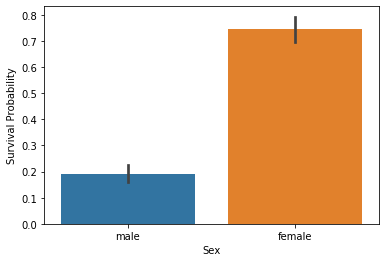

In [115]:
g = sns.barplot(x = 'Sex', y = 'Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [107]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


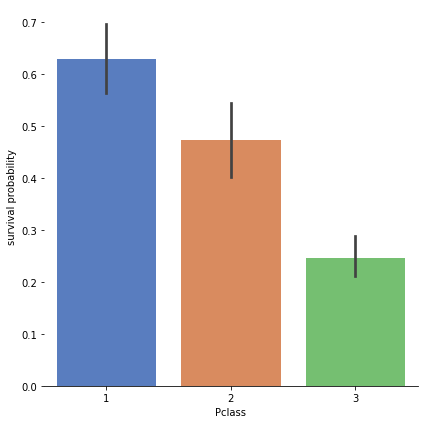

In [117]:
g = sns.catplot(x = 'Pclass', y = 'Survived', data = train, kind = 'bar', height = 6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

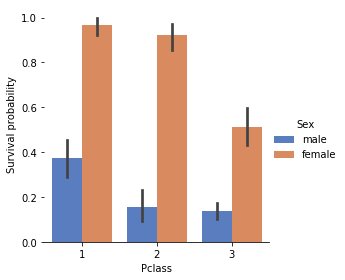

In [118]:
g = sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, height = 4, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival probability')

In [119]:
dataset['Embarked'].isnull().sum()

2

In [120]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

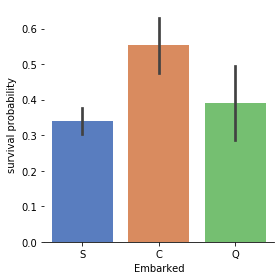

In [123]:
g = sns.catplot(x='Embarked', y = 'Survived', data = train, height = 4, kind = 'bar', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

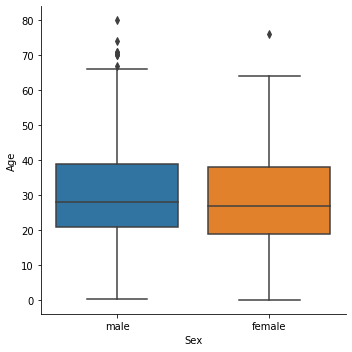

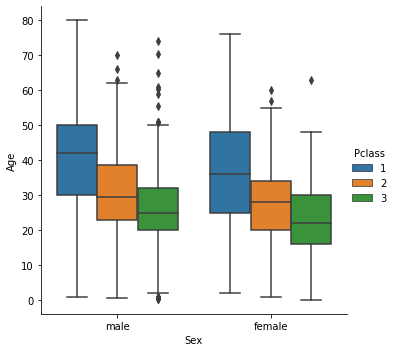

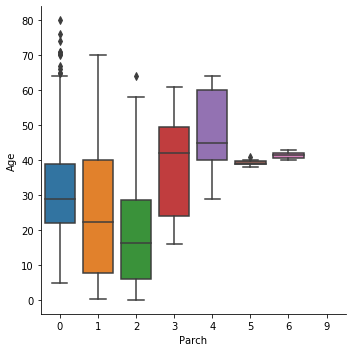

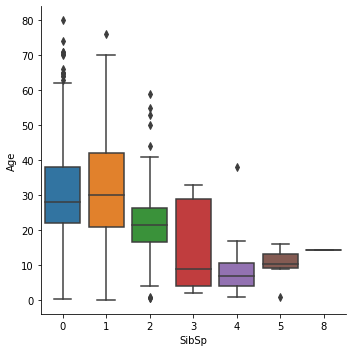

In [129]:
g = sns.catplot(y='Age',x='Sex',data = dataset, kind = 'box')
g = sns.catplot(y='Age',x='Sex',hue='Pclass',data=dataset,kind='box')
g = sns.catplot(y='Age',x='Parch',data=dataset, kind='box')
g = sns.catplot(y='Age',x='SibSp', data=dataset, kind='box')

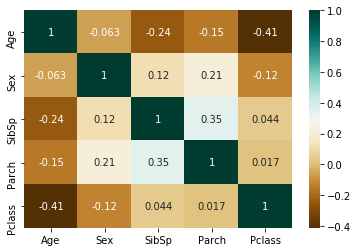

In [131]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})
g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(), cmap='BrBG', annot =True)

In [132]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)
# Age가 결측치인 샘플의 인덱스를 얻는다.
for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp'])&\
                               (dataset['Parch']==dataset.iloc[i]['Parch'])&\
                               (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    
    if not np.isnan(age_pred): 
        dataset['Age'].iloc[i] = age_pred
    else: # 나이가 결측값인 사람의 위 세 피쳐들 역시 결측값이면 전체 나이의 평균으로 대치
        dataset['Age'].iloc[i] = age_med

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


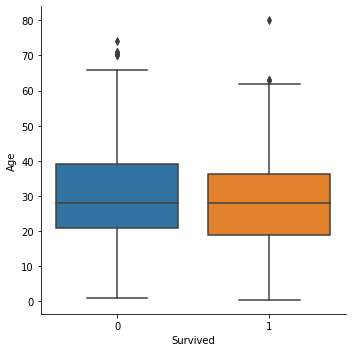

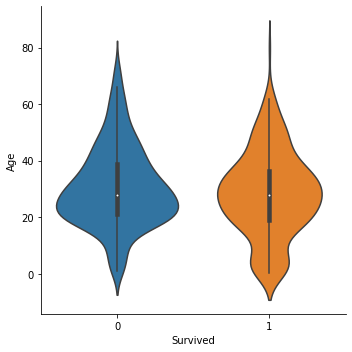

In [133]:
g = sns.catplot(x='Survived', y='Age',data = train, kind='box')
g = sns.catplot(x='Survived', y='Age',data = train, kind='violin')

In [134]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]

dataset['Title'] = dataset_title
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

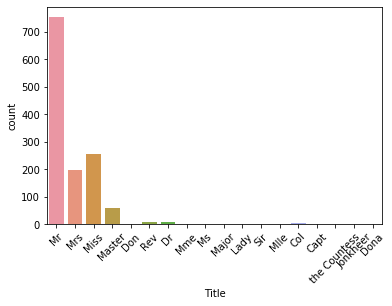

In [135]:
g = sns.countplot(x='Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

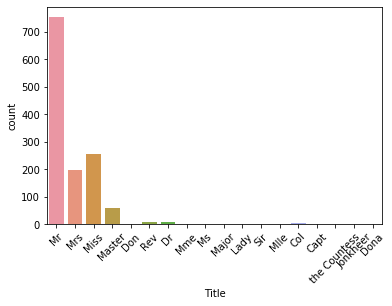

In [139]:
g = sns.countplot(x = 'Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [140]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0,"Miss":1,"Ms":1,"Mme":1,"Mlle":1,"Mrs":1,"Mr":2,"Rare":3})
dataset['Title'] = dataset['Title'].astype(int)

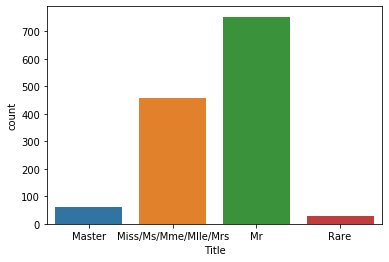

In [141]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs','Mr','Rare'])

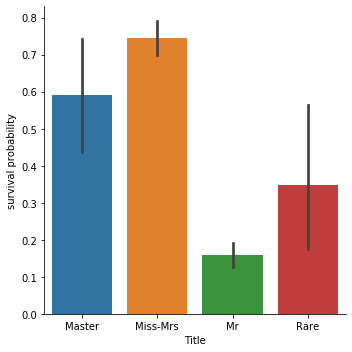

In [143]:
g = sns.catplot(x='Title', y='Survived', data = dataset, kind= 'bar')
g = g.set_xticklabels(['Master','Miss-Mrs','Mr','Rare'])
g = g.set_ylabels('survival probability')

In [144]:
dataset.drop(labels=['Name'], axis = 1, inplace= True)

In [146]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

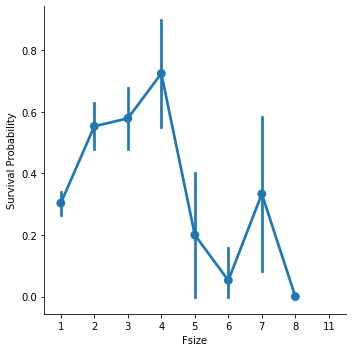

In [150]:
g = sns.catplot(x='Fsize',y='Survived', data = dataset, kind='point')
g = g.set_ylabels('Survival Probability')

In [153]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s ==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

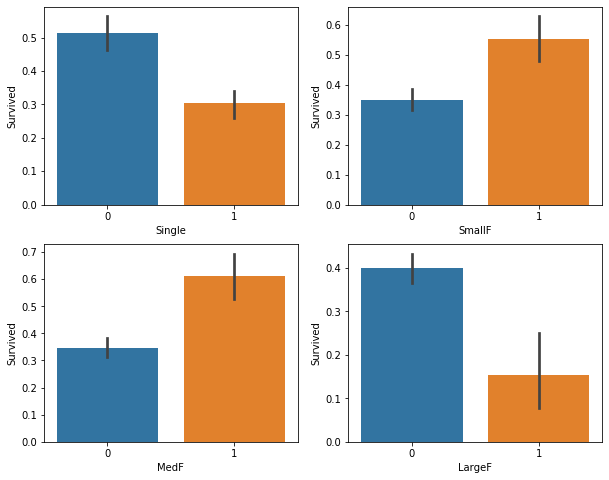

In [161]:
f, ax = plt.subplots(2,2, figsize=(10,8))
sns.barplot(x = 'Single', y='Survived', data = dataset,ax=ax[0,0])
sns.barplot(x = 'SmallF', y='Survived', data = dataset, ax=ax[0,1])
sns.barplot(x = 'MedF', y='Survived', data = dataset, ax=ax[1,0])
sns.barplot(x = 'LargeF', y='Survived', data = dataset, ax=ax[1,1])

In [162]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix = 'Em')

In [163]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [ ]:
# 5.3 Cabin